_WORKING I(N) PROGRESS_
# PREDICTING SURVIVORS - TITANIC

The "Titanic Project" is a common project among people who are starting in Machine Learning.
The goal of the project is to predict is a passenger survived.

The dataset was downloaded from Kaggle. https://www.kaggle.com/code/alexisbcook/titanic-tutorial
It has 418 rows and 12 columns.

-- BEST SCORE IN KAGGLE: 2508/16360 (Top 15%, on August 2024) 🏆

<img src="../img/Klaggle_titanic_08_2024.png" width="40%">

In [3]:
# Essential libraries for data manipulation
import numpy as np #linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graph plots


import seaborn as sns # plots
%matplotlib inline


# basic styling for graphs
plt.style.use('ggplot')

font = {"family": "Azeret Mono",
"weight": "bold",
"size": 14}

plt.rcParams.update({"font.family": font["family"], "font.weight": font["weight"], "font.size": font["size"]})

# loads data
data_train = pd.read_csv("data/00_titanic/train.csv")

# prepare the test set
data_test = pd.read_csv("data/00_titanic/test.csv")
data_test.info()

# prepare path to save model results for comparision
results = "../output/titanic_classification.csv"

# take a glimpse at data
data_train.head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Essential question: Survival rate

print(f"Survival Rate {((data_train['Survived'] == 1).sum()/data_train['Survived'].count()):.3f}")

Survival Rate 0.384


## 1.1 Data Cleaning

Before I start playing, it's necessary to get my hands "dirty" by cleaning the data! 🧻


In [7]:
# get info about data - check amount of null values
print("Train set")
data_train.isna().sum()

Train set


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
print("Test set")
data_test.isna().sum()


Test set


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Checking the number of empty values above, I decided to treat them as following:

- Age: I will use an estimator, the median of ages.
- Cabin: There are a lot of missing values, but the existing ones could tell me something. As I don't know it yet, I will replaced the null values with "UNK", for *unknow*. 
- Embarked: Since we have only two rows with null values in the train set, it's unlikely these rows will make a large difference in the final model. So I will drop them.
- Fare: The test set has one null value for fare. I will replace it by the mean of fares.

In [9]:

# another way to write the code below
# data_train.Age = data_train.Age.fillna(data_train.Age.median())

# first treat the train data
data_train["Age"] = data_train["Age"].fillna(data_train["Age"].median()) # Age
data_train.dropna(subset=["Embarked"], inplace=True) # Embarked
data_train["Cabin"] = data_train["Cabin"].fillna("UNK") # Cabin

# now treat the test data
data_test["Age"] = data_test["Age"].fillna(data_test["Age"].median()) # Age
data_test["Fare"] = data_test["Fare"].fillna(data_test["Fare"].median()) #Fare
data_test["Cabin"] = data_test["Cabin"].fillna("UNK")  # Cabin
# we don't need to treat 'Emabarked' since there are no null values


# from now, I will create the X_train and X_test, removing the features I won't need from this step on
# For example, "the ticket number" can be removed
# Name will be removed after the data engineering step
# Survived will be removed once we start the models, when we set y_train and y_test
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Name", "Cabin"]

X_train = data_train[features].copy()
X_test = data_test[features].copy()

# Adds "survivor to list of features"
# this will be removed after the data visualisation
X_train["Survived"] = data_train["Survived"]



In [10]:
# Just checking
X_train.info()

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    object 
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   Embarked  889 non-null    object 
 7   Name      889 non-null    object 
 8   Cabin     889 non-null    object 
 9   Survived  889 non-null    int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 76.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    

From the data above, I can set my features (X arrays) and y (label for training). While the label will be logically column "Survived", for the choosen features are less obvious. Nevertheless some features are likely to bring little information in future predictions, such as the "name" the passenger, their ticket number, since they are unique. I will move on inspecting those cases. But first, let me see if I can create some new features.

## 1.2 Feature engineering

Now I will explore if some features could be created based based on my  interpreation of the situation. I find this to be an exciting step! You need to combine creativity with logical reasoning, common sense, and the subject knowledge.

This is a fairly simple dataset. After exploring the rows, I decided to create two new columns.

- Family Fame: We can potentially argue that the family name has an influence on the survival chance of a person. If a family was considered prestigious, they could be more likely to survive.
- Number of family members: This was suggested by ChatGPT. I don't have any issues in admiting AI Agents are my friends during working from home (among my three cats 🐱 🐱 🐱)


In [11]:
import re # regular expressions

# family members
# Add new feature using .loc to avoid SettingWithCopyWarning
X_train.loc[:, "N_Family_Members"] = X_train["SibSp"] + X_train["Parch"]
X_test.loc[:, "N_Family_Members"] = X_test["SibSp"] + X_test["Parch"]


# family name
# the condition is treated with regex
# "the first words that appear up the comma, in "Name" 
def extract_family_name(name):
    match = re.match(r'^([^,]+)', name)
    if match:
        return match.group(1)
    else:
        return "Uknown"

# extract the family name and create a new column
X_train["Family_Name"] = X_train["Name"].apply(extract_family_name)
X_test["Family_Name"] = X_test["Name"].apply(extract_family_name)



# reviews the training set, to check if everything looks good
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name,Cabin,Survived,N_Family_Members,Family_Name
0,3,male,22.0,1,0,7.2500,S,"Braund, Mr. Owen Harris",UNK,0,1,Braund
1,1,female,38.0,1,0,71.2833,C,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,1,1,Cumings
2,3,female,26.0,0,0,7.9250,S,"Heikkinen, Miss. Laina",UNK,1,0,Heikkinen
3,1,female,35.0,1,0,53.1000,S,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,1,1,Futrelle
4,3,male,35.0,0,0,8.0500,S,"Allen, Mr. William Henry",UNK,0,0,Allen


In [12]:
# check how many groups were formed from "Family_Name"
print(X_train["Family_Name"].value_counts())

Family_Name
Andersson      9
Sage           7
Skoog          6
Goodwin        6
Johnson        6
              ..
Markoff        1
Abbing         1
Hewlett        1
Vestrom        1
Saundercock    1
Name: count, Length: 665, dtype: int64


In [13]:
# Just checking... 
X_train.info()

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pclass            889 non-null    int64  
 1   Sex               889 non-null    object 
 2   Age               889 non-null    float64
 3   SibSp             889 non-null    int64  
 4   Parch             889 non-null    int64  
 5   Fare              889 non-null    float64
 6   Embarked          889 non-null    object 
 7   Name              889 non-null    object 
 8   Cabin             889 non-null    object 
 9   Survived          889 non-null    int64  
 10  N_Family_Members  889 non-null    int64  
 11  Family_Name       889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            ----

## 1.2 Data Exploration

Some data vis to get familiar with the data. Supported by the graph below, the data tells us that:

- The data is normally distributed for Age, generally and considering the Survivors/Non-survivors
- The survival rate among individuals with the Sex as "Female" is higher than among individuals with the Sex as "Male".
- There is an increase in survival rate according to higher classes. Higher classes have a higher survival rate, while lower classes have a higher rate of non-survivors.
- Passengers of the higher classes have paid more for their fairs.
- **The P-class has the highest degree of association with the survival rate.**
- **Men died more than women**.The percentage of man who didn't survived is higher than the woman who survived.
- Based on the visualisations the features Gender, PClass and Fair seem to have a higher correlation with the survival rate. When I create the models, I will also test one with these "special_features" to compare their performance.

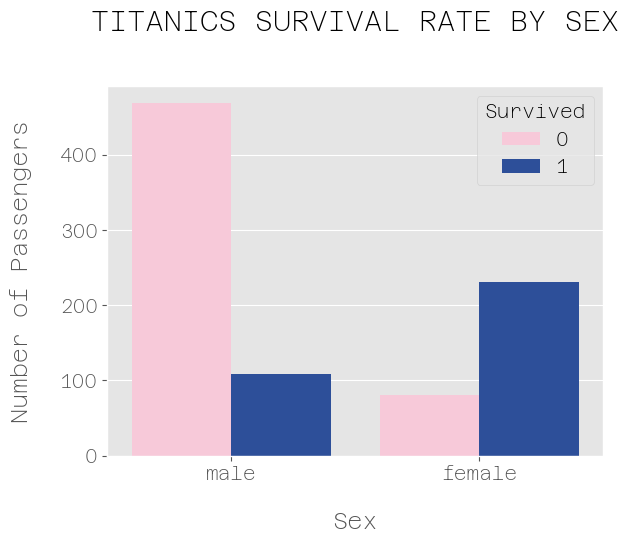

In [14]:
# Survival rate by Gender
sns.countplot(x=X_train["Sex"], hue= X_train[ "Survived"], palette={0: "#ffc1d6", 1: "#1b48ab"})
plt.xlabel("Sex", labelpad=20)
plt.ylabel("Number of Passengers", labelpad=20)
plt.title("TITANICS SURVIVAL RATE BY SEX", pad=40, fontweight='bold')
plt.show()

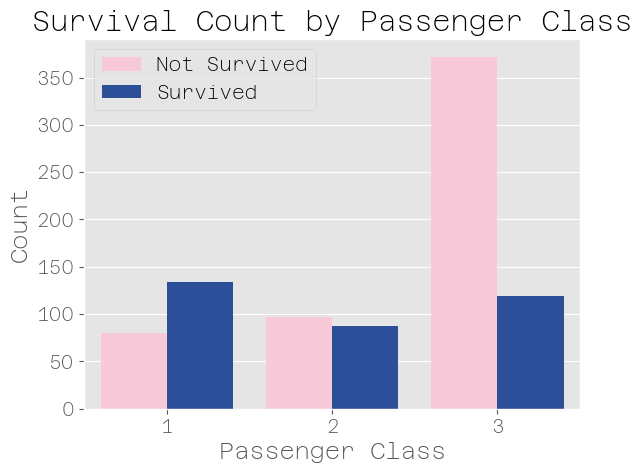

In [15]:
# Survival rate by Class
# Is the certain class more likely to survive than others?

sns.countplot(x="Pclass", hue="Survived", data=data_train, palette={0: "#ffc1d6", 1: "#1b48ab"})

plt.title("Survival Count by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Count")
plt.legend(["Not Survived", "Survived"])
plt.show()

In [16]:
# Survival rate by Cabin
X_train.Cabin.value_counts()

Cabin
UNK            687
C23 C25 C27      4
G6               4
B96 B98          4
F33              3
              ... 
E17              1
A24              1
C50              1
B42              1
C148             1
Name: count, Length: 147, dtype: int64

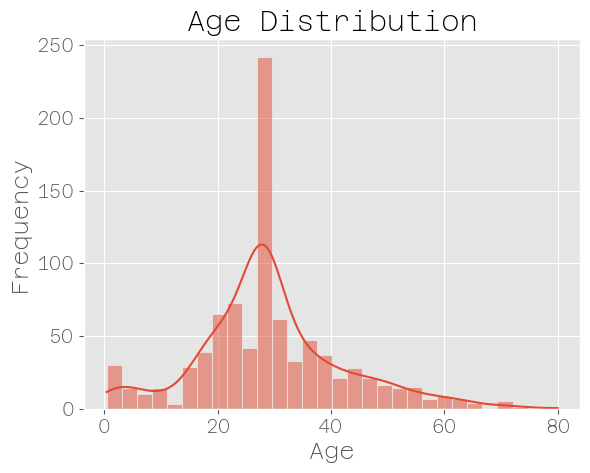

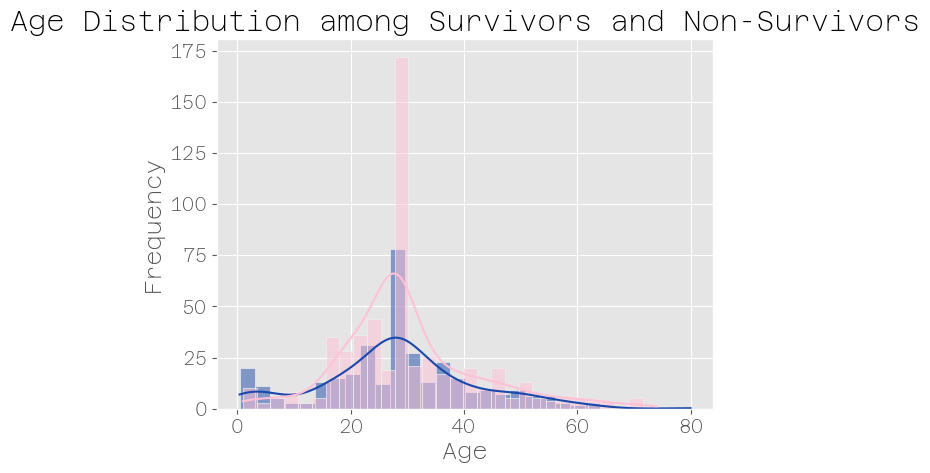

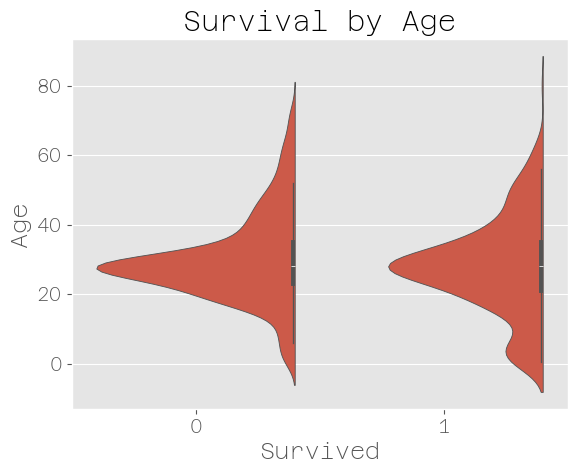

In [17]:
# Age Distribution
# Distribution plot of ages
sns.histplot(X_train['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Filter data for survivors and non-survivors
survived_data = X_train[X_train['Survived'] == 1]['Age']
not_survived_data = X_train[X_train['Survived'] == 0]['Age']

# Create distribution plots for survivors and non-survivors
sns.histplot(survived_data, bins=30, kde=True, color='#1b48ab', label='Survived')
sns.histplot(not_survived_data, bins=30, kde=True, color='#ffc1d6', label='Not Survived')

# Add labels and title
plt.title('Age Distribution among Survivors and Non-Survivors')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Survival rate by age
# Violin plot of age by survival
sns.violinplot(x='Survived', y='Age', data=X_train, split=True)
plt.title('Survival by Age')
plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()

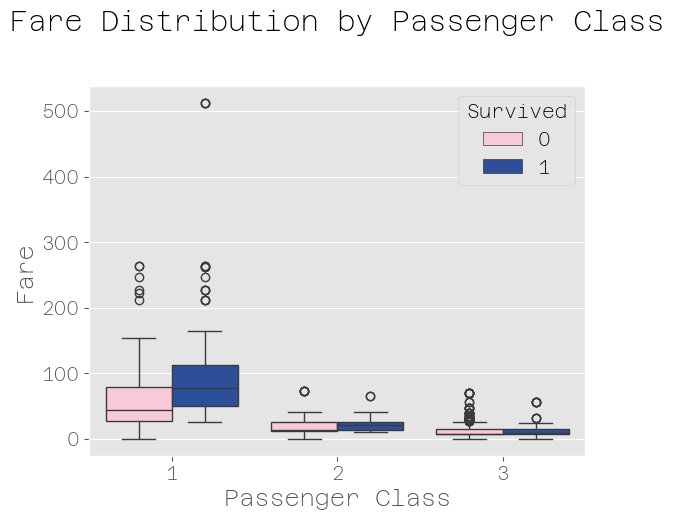

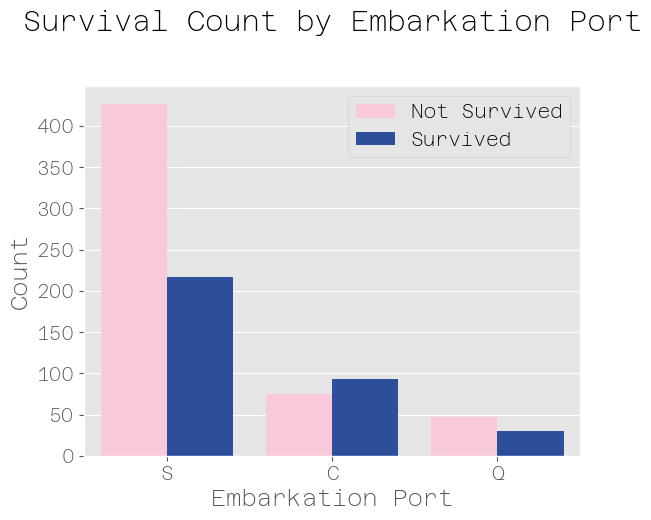

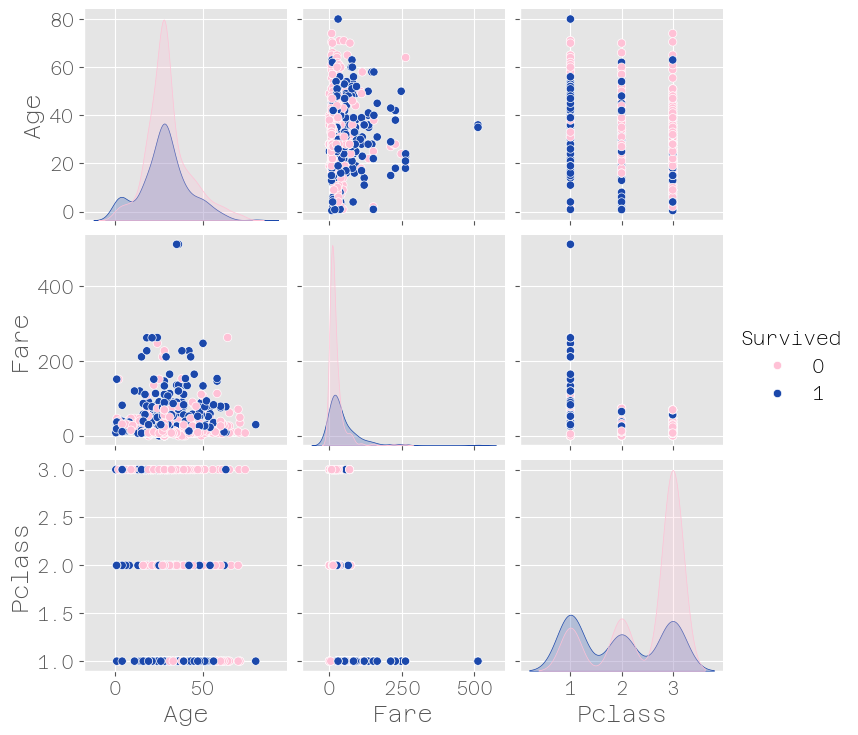

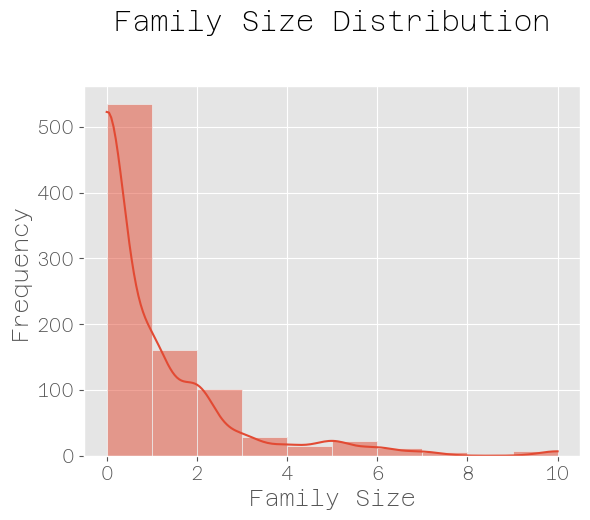

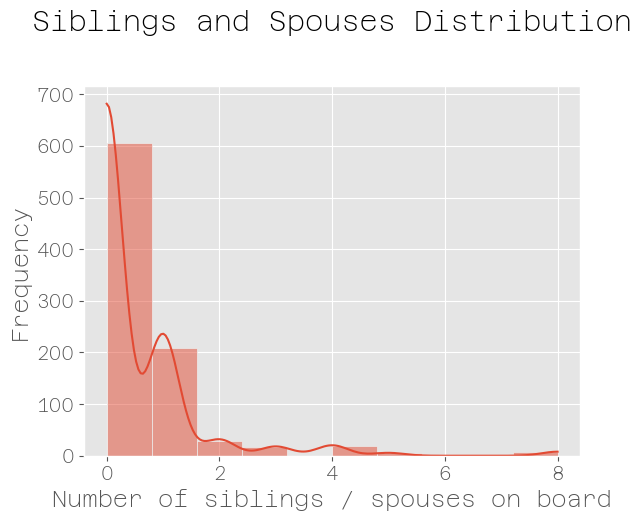

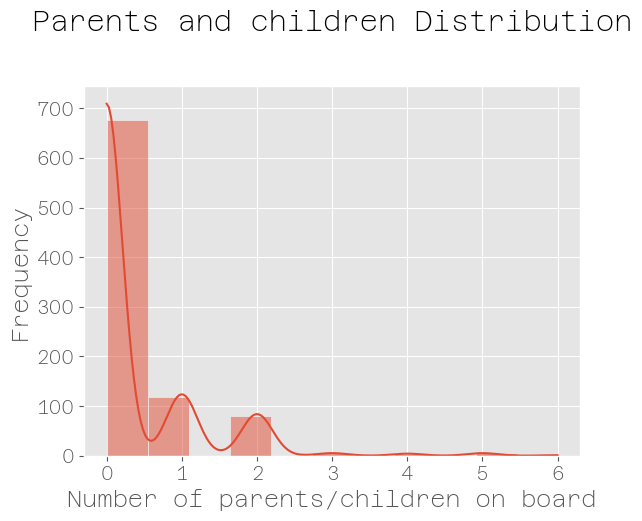

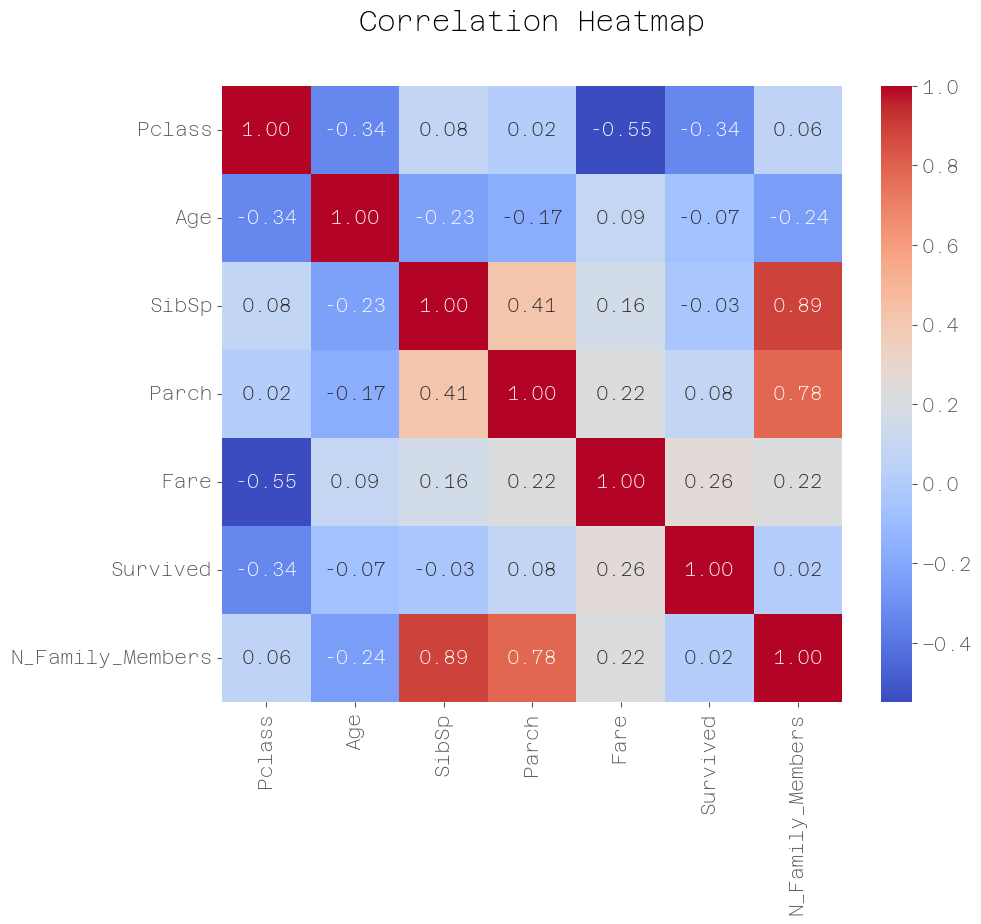

In [18]:
# Fare distribution by Class
# Box plot of fare by passenger class
sns.boxplot(x='Pclass', y='Fare', hue="Survived", data=X_train, palette={0: "#ffc1d6", 1: "#1b48ab"})
plt.title('Fare Distribution by Passenger Class', pad=40)
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.show()

# Survival Rate by Embarkation Port
# Count plot of survival by embarkation port
sns.countplot(x='Embarked', hue='Survived', data=X_train, palette={0: "#ffc1d6", 1: "#1b48ab"})
plt.title('Survival Count by Embarkation Port', pad=40)
plt.xlabel('Embarkation Port')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'])
plt.show()


# Pairplot of Features
# Pairplot of selected features
sns.pairplot(X_train[['Age', 'Fare', 'Pclass', 'Survived']], hue='Survived', palette={0: "#ffc1d6", 1: "#1b48ab"})
plt.show()


# Family Size Distribution
sns.histplot(X_train['N_Family_Members'], bins=10, kde=True)
plt.title('Family Size Distribution', pad=40)
plt.xlabel('Family Size')
plt.ylabel('Frequency')
plt.show()

# Sib Distribution
sns.histplot(X_train['SibSp'], bins=10, kde=True)
plt.title('Siblings and Spouses Distribution', pad=40)
plt.xlabel('Number of siblings / spouses on board')
plt.ylabel('Frequency')
plt.show()

# Parch distribution
sns.histplot(X_train['Parch'], kde=True)
plt.title("Parents and children Distribution", pad=40)
plt.xlabel("Number of parents/children on board")
plt.ylabel("Frequency")
plt.show()

# Correlation Heatmap

# Drop non-numeric columns
numeric_columns = X_train.select_dtypes(include=['number']).columns
X_train_numeric = X_train[numeric_columns]

# Calculate correlation matrix
correlation_matrix = X_train_numeric.corr()
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', pad=40)
plt.show()




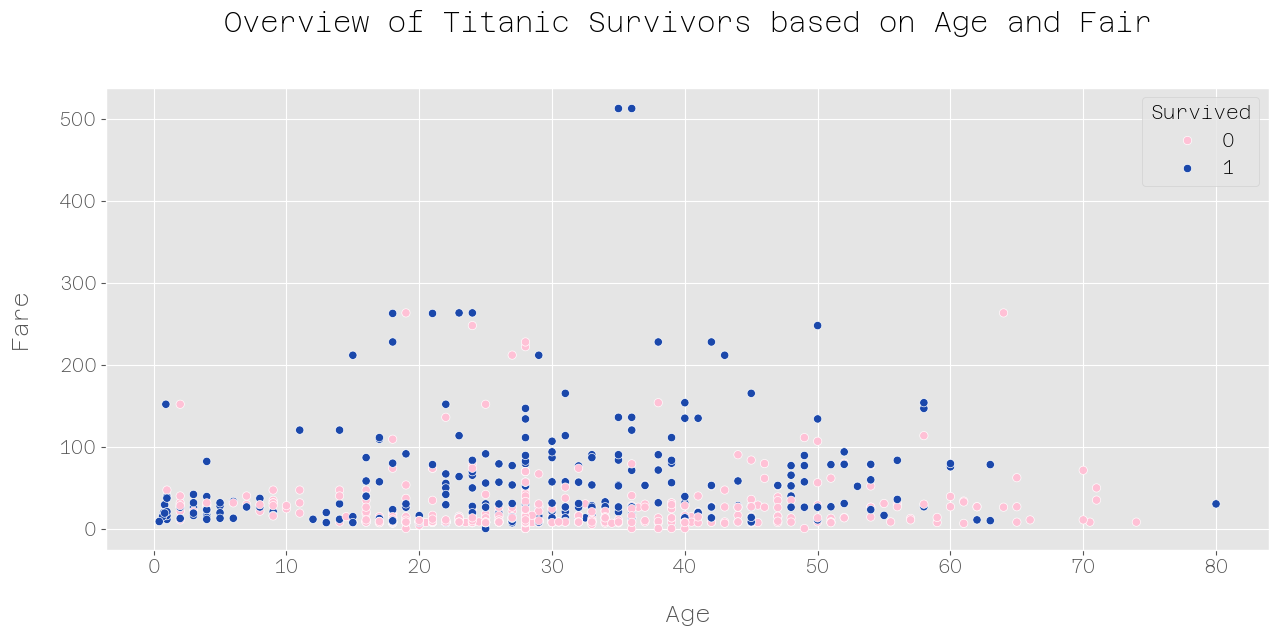

In [19]:
plt.figure(figsize=(15, 6))

# plot overview based on age and fair
sns.scatterplot(y=data_train["Fare"], x=data_train["Age"], hue=data_train["Survived"], palette={0: "#ffc1d6", 1: "#1b48ab"})

plt.xlabel("Age", labelpad=20)
plt.ylabel("Fare", labelpad=20)
plt.title("Overview of Titanic Survivors based on Age and Fair", pad=40)

plt.show()

/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

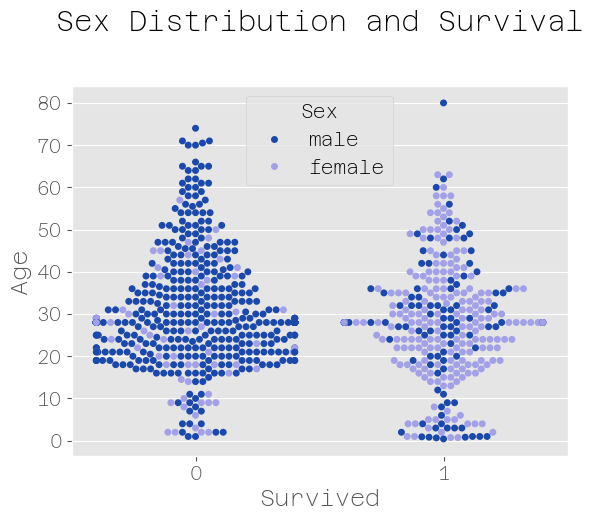

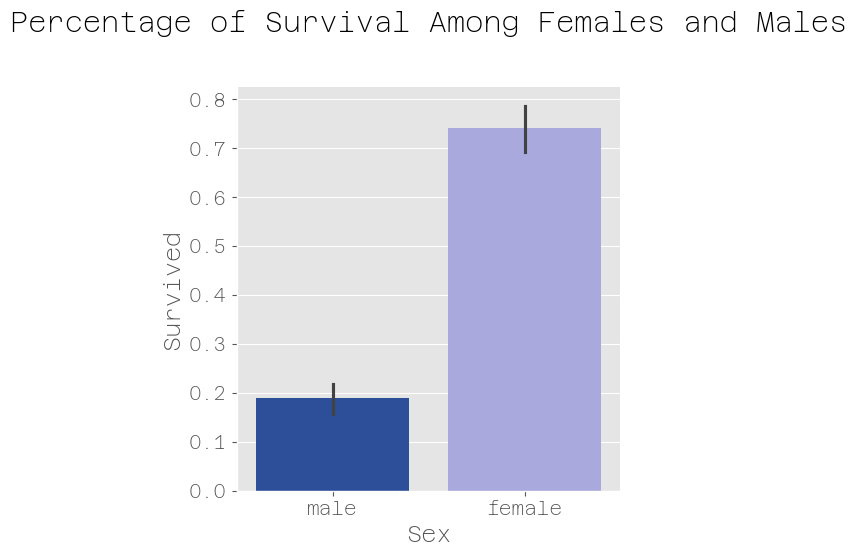

/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gabi/data_science/data_science/ve_ml/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

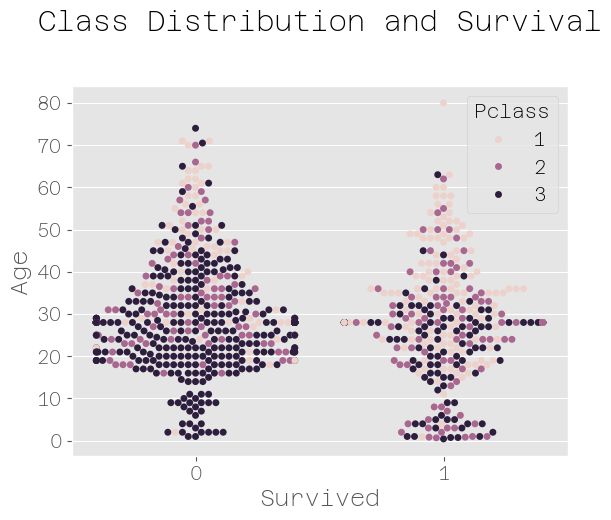

In [20]:
# with the swarm plot we can potentially see some clusters in the data
sns.swarmplot(x="Survived", y= "Age", hue="Sex", data=data_train, palette={"female": "#a2a0e7", "male": "#1b48ab"})
plt.title("Sex Distribution and Survival", pad=40)
plt.show()

sns.catplot(x = "Sex",y = "Survived",hue = "Sex", kind = "bar", data = data_train,
palette={"female": "#a2a0e7", "male": "#1b48ab", })
# Breakdown by gender within Survived category, )
plt.title("Percentage of Survival Among Females and Males", pad=40)
plt.show()

# class distribition and survival
sns.swarmplot(x="Survived", y= "Age", hue="Pclass", data=data_train)
plt.title("Class Distribution and Survival", pad=40)
plt.show()





## 1.4 (Pre) Data Encoding

Next, I will move on by encoding the categorical variables. Before follow with the enconding, it is good to check if the data is consistent.

In [ ]:
# check if data is consistent for all columns with object type - what will be enconded
print(X_train.info())
print(f"\n\n{X_train.Sex.value_counts()}")



In [ ]:
print(X_train.Embarked.value_counts())



In [ ]:
print(X_train.Family_Name.value_counts())

"Family_Name"

## 1.5 *Machine Learning Models* 

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# evaluation metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer


# Define the OneHotEncoder for categorical features
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# create the labels
y_train = X_train["Survived"]

# select features
#features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked", "Cabin", "N_Family_Members", "Family_Name", "Fare"]
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Parch"]



# create a subset of X_train with the features available to use
X_train_selected = X_train[features]
X_test_selected = X_test[features]




In [ ]:
# encoded
#X_train_encoded = pd.get_dummies(X_train_selected)
#X_test_encoded = pd.get_dummies(X_test_selected)

# create test & validation+train
X_trainval_model,  X_test_model, y_trainval_model, y_test_model = train_test_split(X_train_selected, y_train, test_size=0.1, random_state=25)

# create validation and train sets
X_train_model, X_validation, y_train_model, y_validation = train_test_split(X_trainval_model, y_trainval_model, test_size=0.2, random_state=25)

print(f"Test Set Size: {X_test_model.shape}")
print(f"Train Set Size: {X_train_model.shape}")
print(f"Validation Set Size: {X_validation.shape}")

all_models = []



X_train_model.info()

In [ ]:
# Random Forest Classifier with Grid Search

# define parameter grid
parameter_grid = {
    "randomforestclassifier__n_estimators": [50, 100, 200, 300, 400, 500], # this is the number of trees
    "randomforestclassifier__max_depth": [None, 5, 10, 20, 30, 40, 50],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__max_features": ["auto", "sqtr", "log2"],
    "randomforestclassifier__bootstrap": [True, False]

}

# initialise the random forest
# m_forest = RandomForestClassifier(random_state=25)

pipe = make_pipeline(RandomForestClassifier(random_state=25))

grid_random_forest = GridSearchCV(pipe, parameter_grid, cv=5)

grid_random_forest.fit(X_train_model, y_train_model)

# Make predictions and get probabilities
y_pred = grid_random_forest.predict(X_test_model)
y_proba = grid_random_forest.predict_proba(X_test_model)[:, 1]  # Probability of survived class

# Calculate AUC score
auc = roc_auc_score(y_test_model, y_proba)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_model, y_pred)
precision = precision_score(y_test_model, y_pred)
recall = recall_score(y_test_model, y_pred)

# save results
model_results = {"model": "Random Forest",
                    "parameters":grid_random_forest.best_params_,
                    "best cv score": grid_random_forest.best_score_,
                    "validation score": grid_random_forest.score(X_validation, y_validation),
                    "test score": grid_random_forest.score(X_test_model, y_test_model),
                    "AUC": auc,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall }

all_models.append(model_results)

# print results
for key, value in model_results.items():
    print(f"{key} : {value}")


In [ ]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Apply OneHotEncoder to categorical columns
        ("cat", one_hot_encoder, ["Sex", "Embarked"]),
        # Apply PowerTransformer to left-skewed columns
        ("skewed", PowerTransformer(), ["Fare", "Parch"]),
        # Leave "Age" out for now; it will be handled in the pipeline
        ("identity", "passthrough", ["Age"])
    ],
    remainder='drop'  # Drop any other columns not specified
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ('age_scaler', StandardScaler()),  # Name the step 'scaler'
    ('classifier', GradientBoostingClassifier())
])


parameter_grid = [
{"classifier": [GradientBoostingClassifier()],
"age_scaler":[StandardScaler(), MinMaxScaler()],
'classifier__n_estimators': [100, 200, 300], #number of trees
'classifier__learning_rate': [0.001,0.005,0.01],
'classifier__max_depth': [5, 8,10],
'classifier__min_samples_split': [2, 5, 10],
'classifier__min_samples_leaf': [4, 6, 8],
'classifier__subsample': [0.2,0.5, 0.8],
"classifier__max_features": ['auto', 'sqrt', 'log2', None] }

]



stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_gbc = GridSearchCV(pipe, parameter_grid, cv=stratified_cv, n_jobs=-1)
grid_gbc.fit(X_train_model, y_train_model)



# Make predictions and get probabilities
y_pred = grid_gbc.predict(X_test_model)
y_proba = grid_gbc.predict_proba(X_test_model)[:, 1]  # Probability of survived class

# Calculate AUC score
auc = roc_auc_score(y_test_model, y_proba)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_model, y_pred)
precision = precision_score(y_test_model, y_pred)
recall = recall_score(y_test_model, y_pred)

# save results
model_results = {"model": "Gradient Boosting Classifier",
                    "parameters":grid_gbc.best_params_,
                    "best cv score": grid_gbc.best_score_,
                    "validation score": grid_gbc.score(X_validation, y_validation),
                    "test score": grid_gbc.score(X_test_model, y_test_model),
                    "AUC": auc,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall }

all_models.append(model_results)

In [ ]:
# SVC model
from sklearn.svm import SVC

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()), # step 01: scale the data
        ("svc", SVC(probability=True)) # apply svc
    ]
)

parameter_grid = {
    'svc__C': [0.01, 1, 100],        # Range of C values
    'svc__gamma': [0.01 , 1, 100], # Range of gamma values
    'svc__kernel': ["linear", "rgb"],    # Different kernels
    "svc__degree": [2, 3] # for the poly variation
}

grid_svc = GridSearchCV(pipeline, parameter_grid, cv=5, scoring='accuracy', n_jobs=-3)
grid_svc.fit(X_train_model, y_train_model)

# Make predictions and get probabilities
y_pred = grid_svc.predict(X_test_model)
y_proba = grid_svc.predict_proba(X_test_model)[:, 1]  # Probability of survived class

# Calculate AUC score
auc = roc_auc_score(y_test_model, y_proba)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_model, y_pred)
precision = precision_score(y_test_model, y_pred)
recall = recall_score(y_test_model, y_pred)

# save results
model_results = {"model": "Support Vector Machine",
                    "parameters":grid_svc.best_params_,
                    "best cv score": grid_svc.best_score_,
                    "validation score": grid_svc.score(X_validation, y_validation),
                    "test score": grid_svc.score(X_test_model, y_test_model),
                    "AUC": auc,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall }

all_models.append(model_results)

# print results
for key, value in model_results.items():
    print(f"{key} : {value}")

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, PolynomialFeatures

#pipe = make_pipeline(("scaler", StandardScaler()), #placeholder for the scaler
#("logisticregression", LogisticRegression(max_iter=1000)))

# Define the OneHotEncoder for categorical features
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Apply OneHotEncoder to categorical columns
        ("cat", one_hot_encoder, ["Sex"]),
        # Apply PowerTransformer to left-skewed columns
        ("skewed", PowerTransformer(), ["Fare"]),
        # Leave "Age" out for now; it will be handled in the pipeline
        ("identity", "passthrough", ["Age"])
    ],
    remainder='drop'  # Drop any other columns not specified
)

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ('age_scaler', StandardScaler()),  # Name the step 'scaler'
    ('poly', PolynomialFeatures(include_bias=False)),  # Include PolynomialFeatures
    ('logisticregression', LogisticRegression(max_iter=1000))  # Name the step 'logisticregression'
])

# for the parameter grid it is important to use the name given by 'make_pipeline'
# you can see this with the function steps

parameter_grid = {
    "age_scaler": [StandardScaler(), MinMaxScaler()],
    "poly__degree": [3, 5],  # Try degrees 1, 2, and 3 for polynomial features
    "logisticregression__C": [0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logisticregression__solver': ['liblinear', 'saga', 'lbfgs'],  # note: 'lbfgs' and 'liblinear' do not support 'elasticnet'
    'logisticregression__max_iter': [100, 200, 500],
    'logisticregression__fit_intercept': [True, False],
    'logisticregression__class_weight': [None, 'balanced']
    }

grid_logreg = GridSearchCV(pipe, parameter_grid, cv=5)

grid_logreg.fit(X_train_model, y_train_model)


# Make predictions and get probabilities
y_pred = grid_logreg.predict(X_test_model)
y_proba = grid_logreg.predict_proba(X_test_model)[:, 1]  # Probability of survived class

# Calculate AUC score
auc = roc_auc_score(y_test_model, y_proba)
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_model, y_pred)
precision = precision_score(y_test_model, y_pred)
recall = recall_score(y_test_model, y_pred)

# save results
model_results = {"model": "Logistic Regression",
                    "parameters":grid_logreg.best_params_,
                    "best cv score": grid_logreg.best_score_,
                    "validation score": grid_logreg.score(X_validation, y_validation),
                    "test score": grid_logreg.score(X_test_model, y_test_model),
                    "AUC": auc,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall }

all_models.append(model_results)

# print results
for key, value in model_results.items():
    print(f"{key} : {value}")

Further exploration and questions

- Does the features I created helped the model?


In [ ]:
for model in all_models:
    for i in model:
        if i=="model":
            print (model[i])
        if i != "parameters" and i!="model":
            print(f"{i} : {model[i]:.3f}")

    print("==="*30)

In [ ]:
all_models = [all_models[i] for i in [0,1,2,4]]

Now that I found the best parameters for several models, I will move one and check other measures of sucess, in order to decide which model to use in the end.


In [ ]:
from sklearn.ensemble import VotingClassifier

# Define voting scheme (hard or soft)
voting = 'hard'  # Replace with 'soft' for soft voting

# Create the VotingClassifier
ensemble = VotingClassifier(estimators=[('Forest', grid_random_forest), ('LogReg', grid_logreg), ("GBC", grid_gbc)], voting=voting)
ensemble.fit(X_train_model, y_train_model)

print(ensemble.best_params_)

In [ ]:
predictions = grid_logreg.predict(X_test_selected)


output = pd.DataFrame({'PassengerId': data_test.PassengerId, 'Survived': predictions})
output.to_csv('submission_grid_logreg_poly_features.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
print(grid_logreg.best_params_)

In [ ]:
X_test = pd.concat([X_test, data_test["PassengerId"]], axis=1)



In [ ]:
X_test_encoded.info()

In [ ]:
grid_logreg.feature_importances_

In [ ]:
all_models[-1]